# Getting data from the crawler

In [179]:
import psycopg2

In [180]:
db_info = "host=127.0.0.1 dbname=nebula user=nebula password=password"

In [181]:
peerids_filename = "data/peerids.csv"

## Crawls to analyse

In [182]:
crawl_filename = "data/crawl-0-1.csv"

In [183]:
conn = psycopg2.connect(db_info)
cur = conn.cursor()

In [184]:
def update_peerids():
    cur.execute("select id,multi_hash from peers;")
    peerids = {x[0]:x[1] for x in cur.fetchall()} # nebulaID -> peerID
    
    print(peerids[21])
    
    to_add = []
    with open(peerids_filename, 'r') as f:
        # read existing mappings
        lines = f.readlines()
        # get the nebula IDs only
        nebIDs = [int(line.split(',')[0]) for line in lines]
        
        for p in peerids:
            # find missing peers
            if p not in nebIDs:
                # add them to to_add
                to_add.append(str(p)+','+peerids[p]+'\n')
                                    
    with open(peerids_filename, 'a') as f:
        f.writelines(to_add)

In [185]:
def get_crawl_ids():
    cur.execute("select id from crawls;")
    return [c[0] for c in cur.fetchall()]

In [186]:
def store_crawls_in_csv(crawl_ids, filename):
    nebula_peers = []
    for n in crawl_ids:
        cur.execute("select peer_id,neighbor_ids from neighbors where crawl_id="+str(n)+";")
        neighbors_rel = cur.fetchall()
        nebula_peers += [[n, nebula_id, peerids[nebula_id]] + (neighbors if neighbors is not None else []) for (nebula_id, neighbors) in neighbors_rel]
        
    #with open(filename, 'w'):
    f = open(filename, 'w')
    writer = csv.writer(f)
    writer.writerows(nebula_peers)
        
    f.close()

In [187]:
def store_crawl_in_csv(crawl_id, filename):
    cur.execute("select peer_id,neighbor_ids from neighbors where crawl_id="+str(crawl_id)+";")
    neighbors_rel = cur.fetchall()
    
    nebula_peers = []
    for (nebula_id, neighbors) in neighbors_rel:
        s = str(nebula_id) + ','
        for n in neighbors:
            s += str(n) + ','
        s = s[:-1] + '\n'
        nebula_peers.append(s)
    #nebula_peers = [str(nebula_id)+','+peerids[nebula_id] + (neighbors if neighbors is not None else []) for (nebula_id, neighbors) in neighbors_rel]
        
    #with open(filename, 'w'):
    f = open(filename, 'w')
    f.writelines(nebula_peers)
    f.close()

In [189]:
update_peerids()

12D3KooWPjQRKNJnupa1zTsqfRsFn3zkfDB4JJQQazn7H4UNkQp4


In [190]:
get_crawl_ids()

[1]

In [191]:
store_crawl_in_csv(1, crawl_filename)

# Helpers

In [192]:
import multihash as mh
import hashlib as hl
from binary_trie import Trie, bytes_to_bitstring, int_to_bitstring

In [193]:
# turn a peer_id (e.g 12D3KooWEZXjE41uU4EL2gpkAQeDXYok6wghN7wwNVPF5bwkaNfS) to its
# sha256 hash representation (256 bits), used as kademlia identifier
def multihash_to_kad_id(peer_id: str) -> bytes:  
    multi_hash = mh.from_b58_string(peer_id)
    return hl.sha256(multi_hash).digest()

# XOR two bitstring of equal size, the size doesn't need to be a multiple of 8
def xor_bitstring(bs0: str, bs1: str) -> str:
    s = ""
    if len(bs0) == len(bs1):
        for i in range(len(bs0)):
            if bs0[i]==bs1[i]:
                s+='0'
            else:
                s+='1'
    return s

# returns the XOR distance (in bytes) between the two provided bytes arrays
def xor_distance(bytes0: bytes, bytes1: bytes):
    xor=bytearray()
    maxlen=max(len(bytes0), len(bytes1))

    for i in range(maxlen):
        byte0 = bytes0[i if len(bytes0)>len(bytes1) else i-len(bytes1)+len(bytes0)] if i >= maxlen-len(bytes0) else 0
        byte1 = bytes1[i if len(bytes1)>len(bytes0) else i-len(bytes0)+len(bytes1)] if i >= maxlen-len(bytes1) else 0
        xor.append(byte0 ^ byte1)

    return bytes(xor)

# get the corresponding k-bucket for the given XOR distance in bytes
def bucket_number_for_distance(d: bytes) -> int:
    count=0
    # iterate on the bytes from left to right
    for b in d:
        # while the byte==0, add 8 (bits) to the counter
        count+=8
        if b!=0:
            # at the first non null byte, shift right until this byte==0
            while b!=0:
                b>>=1
                # for each right shift, remove 1 to counter
                count-=1
            break
    # return the length of the byte string minus the number of leading 0 bits
    return 256-(8*len(d)-count)


In [194]:
class NebulaPeer:
    def __init__(self, nebula_id, peer_id, neighbors_ids):
        self.nebula_id = nebula_id
        self.peer_id = peer_id
        self.neighbors_ids = neighbors_ids
        
        self.key = multihash_to_kad_id(peer_id)
        
        self.alive = len(neighbors_ids)>0
        
        self.buckets = [[] for _ in range(257)]
        self.neighbors = {}
        
    def distance(self, p):
        return xor_distance(self.key, p.key)
        
    def addNeighbor(self, peer):
        if bytes_to_bitstring(peer.key) not in self.neighbors:
            self.neighbors[bytes_to_bitstring(peer.key)] = peer
            self.buckets[bucket_number_for_distance(self.distance(peer))].append(peer)
        
    def __str__(self):
        return "nebula_id: "+str(self.nebula_id)+", peer_id: "+str(self.peer_id)+", neighbors: "+str(self.neighbors_ids)


# Analysis

## Loading data

In [195]:
# load nebulaID -> peerID map
with open(peerids_filename, 'r') as file:
    nebulaid_peerid = {line.split(',')[0]:line.split(',')[1][:-1] for line in file.readlines()}
    # [:-1] removes the trailing '\n'

In [196]:
# load neighbors
with open(crawl_filename, 'r') as file:
    neighbors_nebula = {line.split(',')[0]:line.split(',')[1:][:-1] for line in file.readlines()}
    # [:-1] removes the trailing '\n'

In [197]:
print(nebulaid_peerid['21'])

12D3KooWPjQRKNJnupa1zTsqfRsFn3zkfDB4JJQQazn7H4UNkQp4


## Building data structures

In [198]:
# build all peers
peers = [NebulaPeer(n, nebulaid_peerid[n], neighbors_nebula[n]) for n in neighbors_nebula]

In [199]:
# make a map for easy access nebulaID -> NebulaPeer
peers_map = {p.nebula_id:p for p in peers}

In [200]:
new_peers = {}
for p in peers:
    for n in p.neighbors_ids:
        if n not in peers_map and n not in new_peers:
            np = NebulaPeer(n, nebulaid_peerid[n], [])
            new_peers[n] = np
            p.addNeighbor(np)
        elif n in new_peers:
            p.addNeighbor(new_peers[n])
        else:
            p.addNeighbor(peers_map[n])

In [201]:
all_peers = []
for i in new_peers:
    all_peers.append(new_peers[i])
for p in peers:
    all_peers.append(p)

In [202]:
t = Trie()
for p in peers:
    t.add(bytes_to_bitstring(p.key), metadata=p)

In [203]:
t.size

10193

## Analysis

In [204]:
print(peers[0].nebula_id)
print(len(peers[0].buckets[7]))
print(peers[0].neighbors['0110001111010011101011101100100010011110111011100010001010001110000100010000010101111000100001101000100110110110100000100110110111100010000010111011111101010111000010100111000111100010000101110111010010111110011100101000010101011111100010100101011000011101'].nebula_id)
p7 = peers[0].neighbors['0110001111010011101011101100100010011110111011100010001010001110000100010000010101111000100001101000100110110110100000100110110111100010000010111011111101010111000010100111000111100010000101110111010010111110011100101000010101011111100010100101011000011101']

dist = p7.distance(peers[0])
print(bytes_to_bitstring(p7.distance(peers[0])))
print(bucket_number_for_distance(dist))
print(p7 in peers[0].buckets[0])

21
19


KeyError: '0110001111010011101011101100100010011110111011100010001010001110000100010000010101111000100001101000100110110110100000100110110111100010000010111011111101010111000010100111000111100010000101110111010010111110011100101000010101011111100010100101011000011101'

In [205]:
print(peers[0].nebula_id)
print(peers[0].peer_id)
print(peers[0].key)


21
12D3KooWPjQRKNJnupa1zTsqfRsFn3zkfDB4JJQQazn7H4UNkQp4
b'\x8c\x11=\xde\xba\xabZ\x15\xa0J\x9cO\xffC\x05\xc5\xe4\xf0k2\xdf\x96\xbe>\x92\xc9-`X\x98\xb1\x97'


In [206]:
for b in peers[50].buckets:
    print(len(b))

20
20
20
20
20
20
20
20
20
20
11
5
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [207]:
# aggregating the number of entries per bucket for all peers
def routing_table_distribution_in_kbuckets(peers):
    routing_table_distribution_in_kbuckets_data = [[] for _ in range(257)]
    routing_table_distribution_in_kbuckets_alive_data = []
    for p in peers:
        for i in range(len(p.buckets)):
            routing_table_distribution_in_kbuckets_data[i].append(len(p.buckets[i]))

            count = 0
            for neighbor in p.buckets[i]:
                if neighbor.alive:
                    count += 1
            routing_table_distribution_in_kbuckets_alive_data.append(count)
    return routing_table_distribution_in_kbuckets_data

In [210]:
import numpy as np
import matplotlib.pyplot as plt

In [211]:
routing_table_distribution_in_kbuckets_data = routing_table_distribution_in_kbuckets(peers)

In [212]:
avg_in_bucket= np.average(routing_table_distribution_in_kbuckets_data, axis=1)

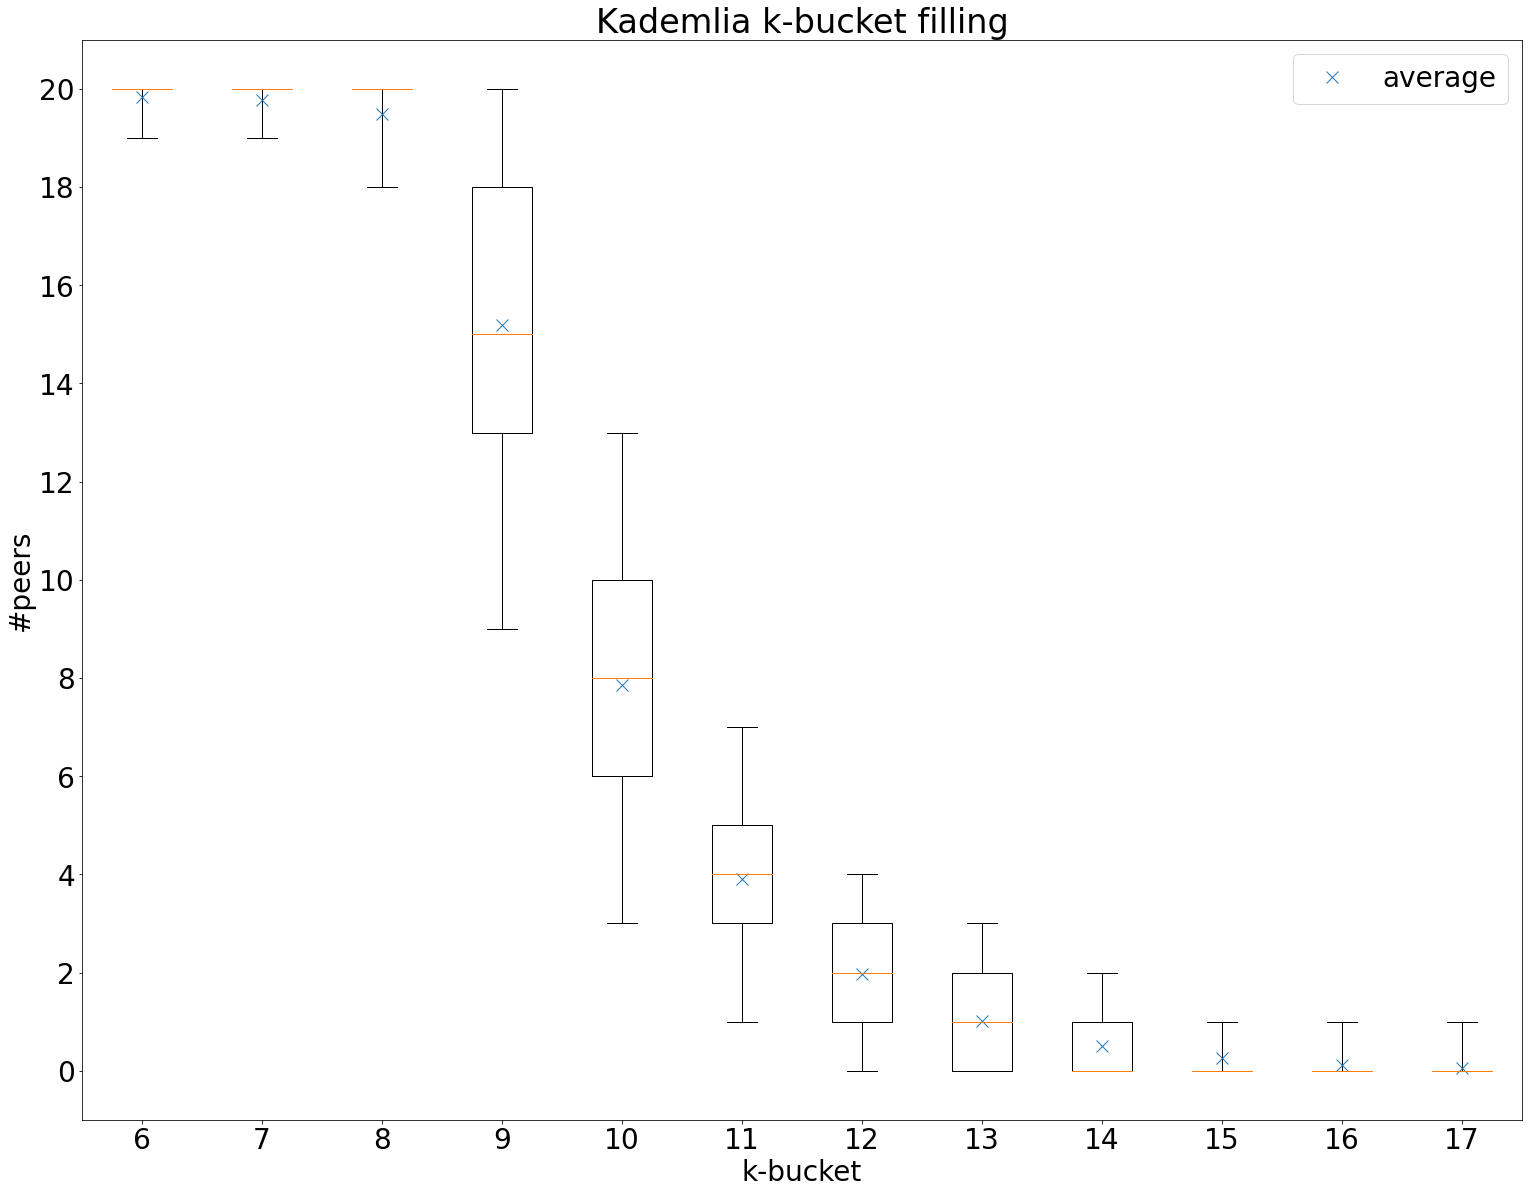

In [216]:
fig = plt.figure(figsize=(20,15), facecolor='white', edgecolor ='black')
ax = fig.add_axes([0, 0, 1, 1])

#ax.set_xlim(220,257)
plt.yticks(range(0, 21, 2))


bp = ax.boxplot(routing_table_distribution_in_kbuckets_data[6:18], positions=range(6,18),\
                showfliers=False, whis=(5, 95))

plt.plot(range(6,18), avg_in_bucket[6:18], marker='x', markersize=12, ls='', label='average')

plt.xlabel("k-bucket")
plt.ylabel("#peers")
plt.grid(False)

plt.title("Kademlia k-bucket filling")
plt.legend()

plt.rc('font', size=28)

plt.savefig("plots/kbucket-filling-distribution-all.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

# show plot
plt.show()